<a href="https://colab.research.google.com/github/NikithaBangera/COMP6721_Artificial_Intelligence/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import block


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import pandas as pd



# Dataset Creation

In [ ]:

#for dirname, _, filenames in os.walk('/content/drive/My Drive/AI Dataset/data'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#with_mask_images = os.listdir("/content/drive/My Drive/AI Dataset/data/with_mask")
#without_mask_images = os.listdir("/content/drive/My Drive/AI Dataset/data/without_mask")
#print(len(with_mask_images))
#print(len(without_mask_images))




  

#dataset = datasets.ImageFolder()
#print(type(dataset))

#for data in dataset:
  #print("Data: ", data)

 

In [ ]:
#PATH_TRAIN_MASK = "/content/drive/My Drive/AI Dataset/data/train/with_mask"
#PATH_VAL_MASK = "/content/drive/My Drive/AI Dataset/data/val/with_mask"
#PATH_TEST_MASK = "/content/drive/My Drive/AI Dataset/data/test/with_mask"

#PATH_TRAIN_NO_MASK = "/content/drive/My Drive/AI Dataset/data/train/without_mask"
#PATH_VAL_NO_MASK = "/content/drive/My Drive/AI Dataset/data/val/without_mask"
#PATH_TEST_NO_MASK = "/content/drive/My Drive/AI Dataset/data/test/without_mask"

#PATH_TRAIN = "/content/drive/My Drive/AI Dataset/data/train"
#PATH_VAL = "/content/drive/My Drive/AI Dataset/data/val"
#PATH_TEST = "/content/drive/My Drive/AI Dataset/data/test"

#print(f'With Mask Train: {len(os.listdir(PATH_TRAIN_MASK))}\n\
#With Mask Validation: {len(os.listdir(PATH_VAL_MASK))}\n\
#With Mask Test: {len(os.listdir(PATH_TEST_MASK))}\n\
#With Mask Total: {len(os.listdir(PATH_TRAIN_MASK))+len(os.listdir(PATH_VAL_MASK))+len(os.listdir(PATH_TEST_MASK))}')

#print(f'Without Mask Train: {len(os.listdir(PATH_TRAIN_NO_MASK))}\n\
#Without Mask Validation: {len(os.listdir(PATH_VAL_NO_MASK))}\n\
#Without Mask Test: {len(os.listdir(PATH_TEST_NO_MASK))}\n\
#Without Mask Total: {len(os.listdir(PATH_TRAIN_NO_MASK))+len(os.listdir(PATH_VAL_NO_MASK))+len(os.listdir(PATH_TEST_NO_MASK))}')

In [ ]:
#rows=20 #rows in subplots
#cols=5 #columns in subplots

#fig,ax = plt.subplots(rows,cols,figsize=(12,100))
#r = 0
#c = 0
#for i in range(rows*cols):
 #   aa = plt.imread(os.path.join("/content/drive/My Drive/AI Dataset/data/without_mask",without_mask_images[i]))
  #  ax[r,c].axis("off")
  #  ax[r,c].imshow(aa)
  #  c+=1
  #  if c == cols:
   #     c=0
    #    r+=1
#plt.show()

In [ ]:
#rows=20 #rows in subplots
#cols=5 #columns in subplots

#fig,ax = plt.subplots(rows,cols,figsize=(12,100))
#r = 0
#c = 0
#for i in range(rows*cols):
 #   aa = plt.imread(os.path.join("/content/drive/My Drive/AI Dataset/data/with_mask",with_mask_images[i]))
  #  ax[r,c].axis("off")
   # ax[r,c].imshow(aa)
    #c+=1
    #if c == cols:
     #   c=0
      #  r+=1
#plt.show()

# Data Loading

In [22]:
image_transforms = transforms.Compose(
                   [transforms.Resize((32,32)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
MAIN = "/content/drive/My Drive/AI Dataset/data/"
dataset = ImageFolder(
                      root = MAIN,
                      transform = image_transforms
                       )

# CIFAR 10 DATASET LOADING
classes = dataset.classes
print(classes)
# dataset.class_to_idx

# dataset.class_to_idx = {'with_mask':1, 'without_mask':0, 'cat':2}
# print(dataset.class_to_idx)
# idx2class = {v: k for k, v in dataset.class_to_idx.items()}
# print(idx2class)

['cat', 'with_mask', 'without_mask']


In [23]:
classes = dataset.classes
classes

['cat', 'with_mask', 'without_mask']

In [5]:
# class_count = {}
# for _, index in dataset:

#     label = classes[index]
#     if label not in class_count:
#         class_count[label] = 0
#     class_count[label] += 1
# class_count

KeyboardInterrupt: ignored

# cifar10 Data set Loading


In [ ]:
dataset1 = CIFAR10(root='/content/drive/My Drive/AI Dataset/data2/', download=True, transform=ToTensor())
classes = dataset1.classes
classes

Extracting /content/drive/My Drive/AI Dataset/data2/cifar-10-python.tar.gz to /content/drive/My Drive/AI Dataset/data2/


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Printing class Distribution

In [ ]:
# def get_class_distribution(dataset_obj):
#     count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
#     for element in dataset_obj:
#         y_lbl = element[1]
#         y_lbl = idx2class[y_lbl]
#         count_dict[y_lbl] += 1
            
#     return count_dict
# print("Distribution of classes: \n", get_class_distribution(dataset))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Distribution of classes: 
 {'cat': 3828, 'with_mask': 3725, 'without_mask': 4999}


# Printing Figures

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


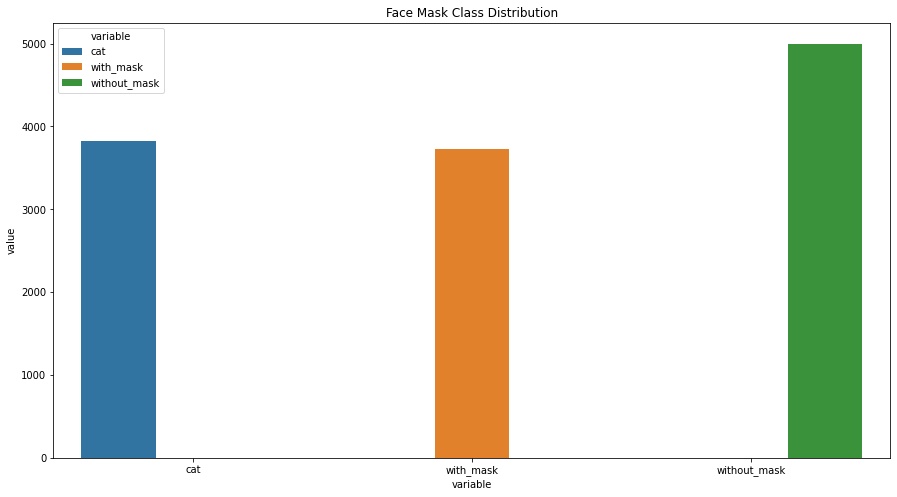

In [ ]:
# plt.figure(figsize=(15,8))
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
# plt.show()

# Split Data- Train and Validation set

In [24]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, (train_size, test_size))

# Loading Data with the help of DataLoader

In [25]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=4, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=4, num_workers=2)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 2511
Length of the val_loader: 628


# Display Images

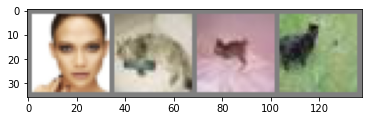

  cat with_mask with_mask with_mask


In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('with_mask', 'without_mask','cat')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Architecture

In [ ]:
#initial architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

In [28]:
net = CNN()

# Loss and Optimizer


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training Network

In [31]:
def images_to_probs(net, images):
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

from tqdm.notebook import tqdm

def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Clearing the RAM
            #del images, labels, outs
            #torch.device('cpu').empty_cache()
        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        print("Accuracy: ",acc)
        print("loss: ",epoch_loss)
        # Model Checkpointing
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    #torch.save(bestmodel,'{0}_{1:0.4f}.pth'.format('classifier',min_loss))
    return None

    print('Training finished!!!')

In [32]:
train(net, criterion, optimizer, train_loader, 2)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Accuracy:  88.99621589324835
loss:  0.4793767069430435


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Accuracy:  95.97689703246365
loss:  0.22639504425378876



# Testing Network

In [33]:
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)

# Prediction 


In [34]:
print("Predicted",[i for i in predlab])
print("Actual",[i for i in testlab])
for i in predlab:
  if i == 0:
    print("without_mask")
  elif i ==1:
    print("with_mask")
  else :
    print("cat")
print("______________________________________________________________________________________________________________")
for i in testlab:
  if i == 0:
    print("without_mask")
  elif i ==1:
    print("with_mask")
  else :
    print("cat")

Predicted [tensor(0), tensor(1), tensor(2), tensor(1)]
Actual [tensor(0), tensor(1), tensor(2), tensor(1)]
without_mask
with_mask
cat
with_mask
______________________________________________________________________________________________________________
without_mask
with_mask
cat
with_mask


# Confusion Matrix

In [35]:
predlab = predlab.to(torch.device('cpu'))
testlab = testlab.to(torch.device('cpu'))
pred = predlab.numpy()
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
print(matrix)

[[1 0 0]
 [0 2 0]
 [0 0 1]]


# Classification Report

In [36]:
report = classification_report(test, pred, target_names=['with_mask','without_mask','cat'])
print(report)  

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00         1
without_mask       1.00      1.00      1.00         2
         cat       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# Convolutional Neural Network Architecture and model training

In [27]:
#requires modifications as per the image pixel and the number of labels
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 64, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 3)
    )

  def forward(self, x):
    #convoltional layers
    x = self.conv_layer(x)

    #flatten the layers
    x = x.view(x.size(0), -1)

    #fc layer
    x = self.fc_layer(x)

    return x

Hyper-paramaters definition

In [19]:
num_epochs = 10
num_classes = 3
learning_rate = 0.001

In [20]:
model = CNN()
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convolutional Neural Network Model Evaluation